In [1]:
from __future__ import absolute_import, division, print_function
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import backend as K

/Users/jon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0527 18:01:47.271806 4443583936 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
#Locate image data
data_root = 'images/train_set'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_root)

Found 220 images belonging to 8 classes.


In [3]:
#get pretrained classifier
feature_extractor_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/3'
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Instructions for updating:
Colocations handled automatically by placer.


W0527 18:01:51.246529 4443583936 deprecation.py:323] From /Users/jon/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
#Image data
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 220 images belonging to 8 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 8)


In [5]:
#Create model
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False
model = tf.keras.Sequential([
    features_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 18:01:58.066874 4443583936 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 10,248
Trainable params: 10,248
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Intialize training session
sess = K.get_session()
init = tf.global_variables_initializer()
sess.run(init)

In [7]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [23]:
#Train
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=10, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/10
1/1 [==============================] - 0s 405ms/step - loss: 0.5104 - acc: 0.9000
Epoch 2/10
1/1 [==============================] - 1s 556ms/step - loss: 0.7756 - acc: 0.6562
Epoch 3/10
1/1 [==============================] - 0s 349ms/step - loss: 0.3050 - acc: 0.9500
Epoch 4/10
1/1 [==============================] - 1s 539ms/step - loss: 0.5167 - acc: 0.8438
Epoch 5/10
1/1 [==============================] - 0s 348ms/step - loss: 0.5853 - acc: 0.8000
Epoch 6/10
1/1 [==============================] - 1s 545ms/step - loss: 0.4628 - acc: 0.8438
Epoch 7/10
1/1 [==============================] - 0s 348ms/step - loss: 0.5305 - acc: 0.8000
Epoch 8/10
1/1 [==============================] - 1s 544ms/step - loss: 0.3945 - acc: 0.9062
Epoch 9/10
1/1 [==============================] - 0s 347ms/step - loss: 0.4834 - acc: 0.8500
Epoch 10/10
1/1 [==============================] - 1s 544ms/step - loss: 0.4114 - acc: 0.9062


In [24]:
#Get label names
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Ahagon_Umiko', 'Hazuki_Shizuku', 'Lijima_Yun', 'Sakura_Nene',
       'Suzukaze_Aoba', 'Takimoto_Hifumi', 'Toyama_Rin', 'Yagami_Kou'],
      dtype='<U15')

In [25]:
#Get predictions
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Sakura_Nene', 'Yagami_Kou', 'Takimoto_Hifumi', 'Hazuki_Shizuku',
       'Sakura_Nene', 'Suzukaze_Aoba', 'Yagami_Kou', 'Hazuki_Shizuku',
       'Lijima_Yun', 'Takimoto_Hifumi', 'Ahagon_Umiko', 'Sakura_Nene',
       'Suzukaze_Aoba', 'Suzukaze_Aoba', 'Toyama_Rin', 'Ahagon_Umiko',
       'Lijima_Yun', 'Ahagon_Umiko', 'Suzukaze_Aoba', 'Suzukaze_Aoba',
       'Ahagon_Umiko', 'Takimoto_Hifumi', 'Suzukaze_Aoba', 'Yagami_Kou',
       'Lijima_Yun', 'Lijima_Yun', 'Lijima_Yun', 'Suzukaze_Aoba',
       'Yagami_Kou', 'Hazuki_Shizuku', 'Sakura_Nene', 'Yagami_Kou'],
      dtype='<U15')

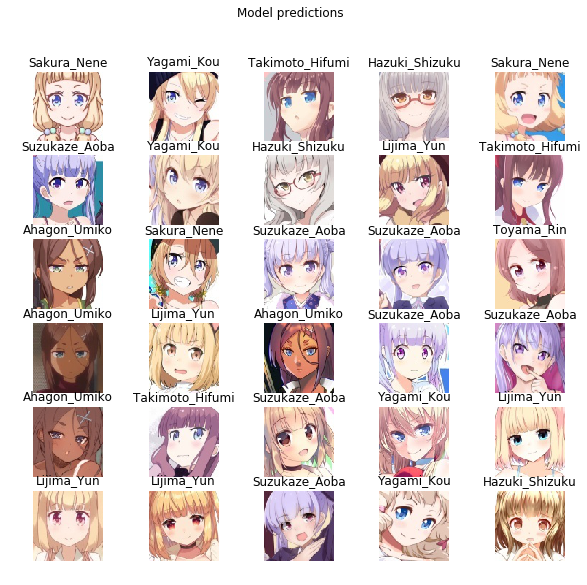

In [26]:
#Visualize predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [27]:
#Save model
if not os.path.exists('models'):
    os.makedirs('models')
saver = tf.train.Saver()
saver.save(sess, 'models/my_model')

'models/my_model'

In [28]:
#Testing the model

#Locate test images
data_root = 'images/test_set'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_root)

Found 52 images belonging to 8 classes.


In [29]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 52 images belonging to 8 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 8)


In [30]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Suzukaze_Aoba', 'Ahagon_Umiko', 'Suzukaze_Aoba', 'Yagami_Kou',
       'Yagami_Kou', 'Suzukaze_Aoba', 'Lijima_Yun', 'Suzukaze_Aoba',
       'Yagami_Kou', 'Takimoto_Hifumi', 'Yagami_Kou', 'Ahagon_Umiko',
       'Takimoto_Hifumi', 'Hazuki_Shizuku', 'Yagami_Kou', 'Toyama_Rin',
       'Lijima_Yun', 'Sakura_Nene', 'Takimoto_Hifumi', 'Sakura_Nene',
       'Yagami_Kou', 'Takimoto_Hifumi', 'Ahagon_Umiko', 'Suzukaze_Aoba',
       'Yagami_Kou', 'Sakura_Nene', 'Takimoto_Hifumi', 'Lijima_Yun',
       'Hazuki_Shizuku', 'Takimoto_Hifumi', 'Hazuki_Shizuku',
       'Lijima_Yun'], dtype='<U15')

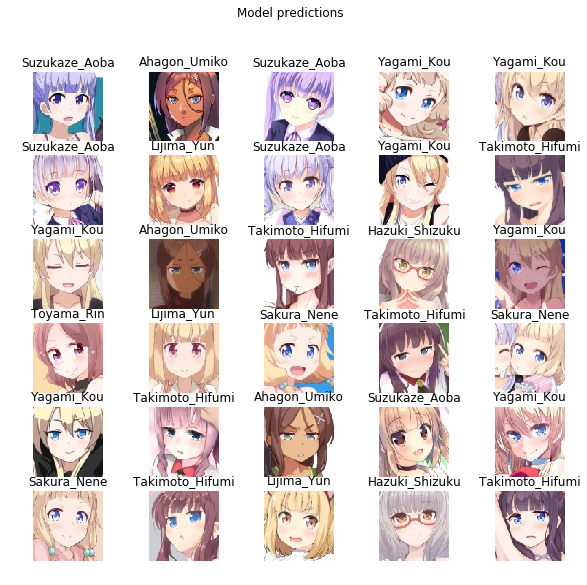

In [31]:
#Visualize predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [32]:
#Accuracy of test set
prediction_indices = []
for arr in result_batch:
    prediction_indices.append(arr.tolist().index(max(arr)))
label_indices = []
for arr in label_batch:
    label_indices.append(arr.tolist().index(max(arr)))
same_count = 0
for i in np.arange(len(prediction_indices)):
    if prediction_indices[i] == label_indices[i]:
        same_count += 1
accuracy = same_count/len(prediction_indices)
print(accuracy)

0.9375
